In [5]:
import sys
sys.path.append('./../')
import tensorflow as tf
print(tf.__version__)

# Helper libraries
from tensorflow import keras
from keras import mixed_precision
import numpy as np
import time
import maxine
import sys
from maxine.layers import SoftMaxMin_Pruned_v02
import keras.backend as k
import pruning_tool_v2
from maxine.tools import pruning_tool_MLP_v3
from maxine.tools import pruning_tool_MLP_v4_1
from maxine.tools import pruning_tool_MLP_v4_2
import tensorflow_model_optimization as tfmot
from keras import regularizers
from keras.callbacks import EarlyStopping
from scipy.io import loadmat
from matplotlib import pyplot as plt

2.13.0


In [2]:
# LOAD DATA
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# rows, cols = 28, 28
# x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
# x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)
# input_shape = (rows, cols, 1)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

# val_labels = y_train[-5000:]
# train_labels = y_train[:-5000]
# test_labels = y_test

# one-hot encode the labels
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)
# Validation data
x_val = x_train[-5000:]
y_val = y_train[-5000:]

x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [3]:
baselineModel = tf.keras.models.load_model('../models/paper/MLP_MNIST_300_100_v2')

2023-12-29 13:10:20.533748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2031] Ignoring visible gpu device (device: 2, name: NVIDIA GeForce GT 1030, pci bus id: 0000:84:00.0, compute capability: 6.1) with core count: 3. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-12-29 13:10:21.886869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23664 MB memory:  -> device: 0, name: Tesla P40, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-12-29 13:10:21.887477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 23664 MB memory:  -> device: 1, name: Tesla P40, pci bus id: 0000:04:00.0, compute capability: 6.1


In [4]:
baselineModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
baselineModel.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 784),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 300,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': {'module': 'keras.regularizers',
     'class_name': 'L2',
     'config': {'l2': 9.999999747378752e-05},
     'registered_name': None},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constrai

In [5]:
baselineModel.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0628 - accuracy: 0.9819


[0.06277354061603546, 0.9818999767303467]

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

p=0

In [8]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=30, mlp_epochs=10, mlp_epochs_refit=40, p=0, optimizer_config=tf.optimizers.serialize(optimizer), extreme=False)

Training morphological model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense (Dense)               (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30


2023-12-29 13:13:45.188424: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x224a97b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 13:13:45.188514: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2023-12-29 13:13:45.188531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla P40, Compute Capability 6.1
2023-12-29 13:13:45.204719: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-29 13:13:45.404831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-12-29 13:13:45.524259: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 13:13:45.724797: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

1719/1719 - 11s - loss: 0.8458 - accuracy: 0.7674 - val_loss: 0.2657 - val_accuracy: 0.9310 - 11s/epoch - 7ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2866 - accuracy: 0.9177 - val_loss: 0.1939 - val_accuracy: 0.9464 - 8s/epoch - 4ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2211 - accuracy: 0.9376 - val_loss: 0.1664 - val_accuracy: 0.9540 - 8s/epoch - 4ms/step
Epoch 4/30
1719/1719 - 8s - loss: 0.1856 - accuracy: 0.9466 - val_loss: 0.1476 - val_accuracy: 0.9578 - 8s/epoch - 4ms/step
Epoch 5/30
1719/1719 - 8s - loss: 0.1623 - accuracy: 0.9525 - val_loss: 0.1243 - val_accuracy: 0.9670 - 8s/epoch - 4ms/step
Epoch 6/30
1719/1719 - 8s - loss: 0.1444 - accuracy: 0.9585 - val_loss: 0.1124 - val_accuracy: 0.9698 - 8s/epoch - 4ms/step
Epoch 7/30
1719/1719 - 8s - loss: 0.1317 - accuracy: 0.9621 - val_loss: 0.1155 - val_accuracy: 0.9656 - 8s/epoch - 4ms/step
Epoch 8/30
1719/1719 - 8s - loss: 0.1207 - accuracy: 0.9651 - val_loss: 0.1097 - val_accuracy: 0.9706 - 8s/epoch - 4ms/step
Epoch 9/30
1719/1

2023-12-29 13:19:18.292953: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sequential/modelLayer_1_0/dropout/random_uniform/RandomUniform


108/108 [==============================] - 5s 28ms/step - loss: 0.6336 - accuracy: 0.8093 - val_loss: 0.2207 - val_accuracy: 0.9388
Epoch 2/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2724 - accuracy: 0.9175 - val_loss: 0.1641 - val_accuracy: 0.9514
Epoch 3/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2149 - accuracy: 0.9346 - val_loss: 0.1354 - val_accuracy: 0.9600
Epoch 4/40
108/108 [==============================] - 0s 4ms/step - loss: 0.1792 - accuracy: 0.9460 - val_loss: 0.1210 - val_accuracy: 0.9646
Epoch 5/40
108/108 [==============================] - 0s 4ms/step - loss: 0.1573 - accuracy: 0.9516 - val_loss: 0.1069 - val_accuracy: 0.9686
Epoch 6/40
108/108 [==============================] - 0s 4ms/step - loss: 0.1397 - accuracy: 0.9567 - val_loss: 0.0997 - val_accuracy: 0.9702
Epoch 7/40
108/108 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9605 - val_loss: 0.0943 - val_accuracy: 0.9726
Epoch 8/40
108/1

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
pruned.compile(optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              jit_compile=True
            ) #from logits = Ture if no activation function on the output
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=128, callbacks=[es])

Epoch 1/40
430/430 [==============================] - 5s 8ms/step - loss: 0.1346 - accuracy: 0.9569 - val_loss: 0.1151 - val_accuracy: 0.9688
Epoch 2/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1242 - accuracy: 0.9601 - val_loss: 0.1077 - val_accuracy: 0.9726
Epoch 3/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1186 - accuracy: 0.9619 - val_loss: 0.1093 - val_accuracy: 0.9712
Epoch 4/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1107 - accuracy: 0.9641 - val_loss: 0.1098 - val_accuracy: 0.9716
Epoch 5/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1104 - accuracy: 0.9648 - val_loss: 0.1017 - val_accuracy: 0.9736
Epoch 6/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1083 - accuracy: 0.9653 - val_loss: 0.1137 - val_accuracy: 0.9702
Epoch 7/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1009 - accuracy: 0.9677 - val_loss: 0.1086 - val_accuracy: 0.9736
Epoch 

In [14]:
pruned.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1101 - accuracy: 0.9702


[0.11006674915552139, 0.9702000021934509]

pruned = 0.9431

In [22]:
activationCount_Mnist300_100_0 = np.load('./activationCount_Mnist300_100_0.npy')
activationCount_Mnist300_100_1 = np.load('./activationCount_Mnist300_100_1.npy')
activationCount_Mnist300_100_2 = np.load('./activationCount_Mnist300_100_2.npy')
w_index_0 = np.arange(0, activationCount_Mnist300_100_0.size)
w_index_1 = np.arange(0, activationCount_Mnist300_100_1.size)
w_index_2 = np.arange(0, activationCount_Mnist300_100_2.size)

Text(0.5, 0.98, 'Lenet 300-100 for Mnist')

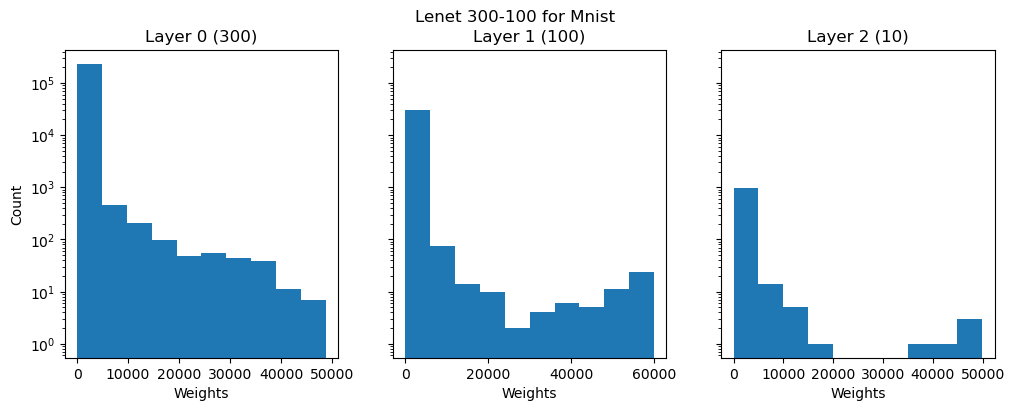

In [116]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4), sharey=True)
axs[0].hist(activationCount_Mnist300_100_0.reshape(-1), log=True)
axs[0].set_xlabel("Weights")
axs[0].set_ylabel("Count")
axs[0].set_title("Layer 0 (300)")
axs[1].hist(activationCount_Mnist300_100_1.reshape(-1), log=True)
axs[1].set_xlabel("Weights")
axs[1].set_title("Layer 1 (100)")
axs[2].hist(activationCount_Mnist300_100_2.reshape(-1), log=True)
axs[2].set_xlabel("Weights")
axs[2].set_title("Layer 2 (10)")

fig.suptitle("Lenet 300-100 for Mnist")


In [94]:
w_index_0_sorted = np.flip(np.argsort(activationCount_Mnist300_100_0.reshape(-1)))
y0 = activationCount_Mnist300_100_0.reshape(-1)[w_index_0_sorted]
x0 = w_index_0
print("Number of zeros of layer 0: " + str(activationCount_Mnist300_100_0.size - np.count_nonzero(activationCount_Mnist300_100_0.reshape(-1))))
w_index_1_sorted = np.flip(np.argsort(activationCount_Mnist300_100_1.reshape(-1)))
y1 = activationCount_Mnist300_100_1.reshape(-1)[w_index_1_sorted]
x1 = w_index_1
print("Number of zeros of layer 1: " + str(activationCount_Mnist300_100_1.size - np.count_nonzero(activationCount_Mnist300_100_1.reshape(-1))))
w_index_2_sorted = np.flip(np.argsort(activationCount_Mnist300_100_2.reshape(-1)))
y2 = activationCount_Mnist300_100_2.reshape(-1)[w_index_2_sorted]
x2 = w_index_2
print("Number of zeros of layer 2: " + str(activationCount_Mnist300_100_2.size - np.count_nonzero(activationCount_Mnist300_100_2.reshape(-1))))

Number of zeros of layer 0: 220420
Number of zeros of layer 1: 22312
Number of zeros of layer 2: 654


In [96]:
p = 0.1
c0 = y0/y0.max() > p
c0 = c0.astype(int)
c1 = y1/y1.max() > p
c1 = c1.astype(int)
c2 = y2/y2.max() > p
c2 = c2.astype(int)

Text(0.5, 0.98, 'Lenet 300-100 for Mnist, p=10%')

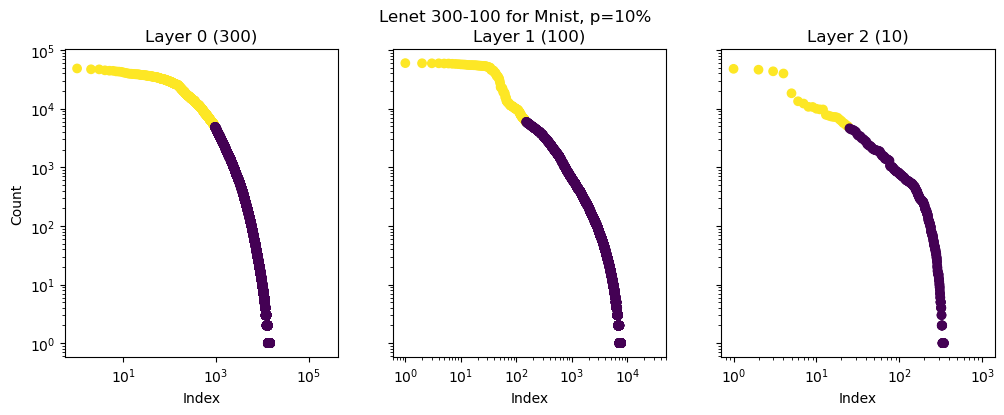

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_adjustable("datalim")
axs[0].scatter(x0, y0, c=c0)
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Index")
axs[0].set_title("Layer 0 (300)")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_adjustable("datalim")
axs[1].scatter(x1, y1, c=c1)
axs[1].set_xlabel("Index")
axs[1].set_title("Layer 1 (100)")

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_adjustable("datalim")
axs[2].scatter(x2, y2, c=c2)
axs[2].set_xlabel("Index")
axs[2].set_title("Layer 2 (10)")

fig.suptitle("Lenet 300-100 for Mnist, p=10%")
# ax.set_xlim(1e5)

p=10

In [5]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=30, mlp_epochs=30, mlp_epochs_refit=40, p=10, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Training morphological model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense (Dense)               (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30


2023-12-05 10:32:53.153152: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fee640043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 10:32:53.153208: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2023-12-05 10:32:53.153221: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla P40, Compute Capability 6.1
2023-12-05 10:32:53.167580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 10:32:53.645124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-12-05 10:32:53.760400: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 10:32:53.957065: I ./tensorflow/compiler/jit/device_compiler.h:186] Co

1719/1719 - 11s - loss: 0.8475 - accuracy: 0.7688 - val_loss: 0.2647 - val_accuracy: 0.9284 - 11s/epoch - 7ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2854 - accuracy: 0.9179 - val_loss: 0.1894 - val_accuracy: 0.9478 - 8s/epoch - 4ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2212 - accuracy: 0.9360 - val_loss: 0.1545 - val_accuracy: 0.9570 - 8s/epoch - 4ms/step
Epoch 4/30
1719/1719 - 8s - loss: 0.1845 - accuracy: 0.9470 - val_loss: 0.1386 - val_accuracy: 0.9612 - 8s/epoch - 4ms/step
Epoch 5/30
1719/1719 - 7s - loss: 0.1606 - accuracy: 0.9546 - val_loss: 0.1194 - val_accuracy: 0.9688 - 7s/epoch - 4ms/step
Epoch 6/30
1719/1719 - 8s - loss: 0.1435 - accuracy: 0.9596 - val_loss: 0.1063 - val_accuracy: 0.9732 - 8s/epoch - 4ms/step
Epoch 7/30
1719/1719 - 8s - loss: 0.1297 - accuracy: 0.9631 - val_loss: 0.1008 - val_accuracy: 0.9734 - 8s/epoch - 4ms/step
Epoch 8/30
1719/1719 - 8s - loss: 0.1195 - accuracy: 0.9658 - val_loss: 0.1086 - val_accuracy: 0.9704 - 8s/epoch - 4ms/step
Epoch 9/30
1719/1

2023-12-05 10:38:25.918071: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sequential/modelLayer_1_0/dropout/random_uniform/RandomUniform


108/108 [==============================] - 5s 28ms/step - loss: 1.1825 - accuracy: 0.6609 - val_loss: 0.4468 - val_accuracy: 0.8826
Epoch 2/40
108/108 [==============================] - 0s 4ms/step - loss: 0.4939 - accuracy: 0.8539 - val_loss: 0.2929 - val_accuracy: 0.9202
Epoch 3/40
108/108 [==============================] - 0s 4ms/step - loss: 0.3847 - accuracy: 0.8869 - val_loss: 0.2361 - val_accuracy: 0.9362
Epoch 4/40
108/108 [==============================] - 0s 4ms/step - loss: 0.3317 - accuracy: 0.9013 - val_loss: 0.2041 - val_accuracy: 0.9434
Epoch 5/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2936 - accuracy: 0.9107 - val_loss: 0.1820 - val_accuracy: 0.9490
Epoch 6/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2648 - accuracy: 0.9212 - val_loss: 0.1636 - val_accuracy: 0.9578
Epoch 7/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2436 - accuracy: 0.9276 - val_loss: 0.1480 - val_accuracy: 0.9610
Epoch 8/40
108/1

In [10]:
pruned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modelLayer_0_1 (Dense)      (None, 300)               235500    
                                                                 
 modelLayer_1_1 (Dropout)    (None, 300)               0         
                                                                 
 modelLayer_2_1 (Dense)      (None, 100)               30100     
                                                                 
 modelLayer_3_1 (Dropout)    (None, 100)               0         
                                                                 
 modelLayer_4_1 (Dense)      (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
w0 = pruned.layers[0].get_weights()[0]
w1 = pruned.layers[2].get_weights()[0]
params_prunedModel = pruned.count_params() - (w0.size - np.count_nonzero(w0) + w1.size - np.count_nonzero(w1))
print("Parámetros mdoelo sin prunar: " + str(pruned.count_params()))
print("Parámetros mdoelo prunado: " + str(params_prunedModel))
print("Pesos restantes: " + str(params_prunedModel/pruned.count_params()*100) + '%')

Parámetros mdoelo sin prunar: 266610
Parámetros mdoelo prunado: 2575
Pesos restantes: 0.9658302389257717%


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
pruned.compile(optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              jit_compile=True
            ) #from logits = Ture if no activation function on the output

In [13]:
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3804 - accuracy: 0.8837 - val_loss: 0.2156 - val_accuracy: 0.9334
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3792 - accuracy: 0.8823 - val_loss: 0.2150 - val_accuracy: 0.9338
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3780 - accuracy: 0.8825 - val_loss: 0.2155 - val_accuracy: 0.9334
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3819 - accuracy: 0.8814 - val_loss: 0.2155 - val_accuracy: 0.9324
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3803 - accuracy: 0.8823 - val_loss: 0.2154 - val_accuracy: 0.9330
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3847 - accuracy: 0.8816 - val_loss: 0.2156 - val_accuracy: 0.9332
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3786 - accuracy: 0.8817 - val_loss: 0.2158 - val_accuracy:

In [14]:
pruned.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2498 - accuracy: 0.9238


[0.24978134036064148, 0.923799991607666]

p=20

In [16]:
baselineModel = tf.keras.models.load_model('../models/MLP_MNIST_300_100')

In [17]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=20, mlp_epochs=30, mlp_epochs_refit=30, p=20, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min_2 (SoftMaxMin  (55000, 300)              235200    
 )                                                               
                                                                 
 dense_4 (Dense)             (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1719/1719 - 10s - loss: 0.8448 - accuracy: 0.7675 - val_loss: 0.2625 - val_accuracy: 0.9314 - 10s/epoch - 6ms/step
Epoch 2/20
1719/1719 - 8s - loss: 0.2836 - accuracy: 0.9182 - val_loss: 0.1917 - val_accuracy: 0.9460 - 8s/epoch - 4ms/step
Epoch 3/20
1719/1719 - 8s - loss: 0.2181 - accuracy: 0.9369 - val_loss: 0.1561 - val_accuracy:

p=5

In [5]:
baselineModel = tf.keras.models.load_model('../models/paper/MLP_MNIST_300_100_v2')

In [6]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=30, mlp_epochs=30, mlp_epochs_refit=30, p=5, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Training morphological model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense (Dense)               (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30


2023-12-05 10:52:32.197775: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x24581680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 10:52:32.197846: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2023-12-05 10:52:32.197862: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla P40, Compute Capability 6.1
2023-12-05 10:52:32.214013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 10:52:32.684701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-12-05 10:52:32.801368: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 10:52:33.002769: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

1719/1719 - 12s - loss: 0.8523 - accuracy: 0.7648 - val_loss: 0.2679 - val_accuracy: 0.9310 - 12s/epoch - 7ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2856 - accuracy: 0.9174 - val_loss: 0.1912 - val_accuracy: 0.9492 - 8s/epoch - 4ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2213 - accuracy: 0.9361 - val_loss: 0.1539 - val_accuracy: 0.9562 - 8s/epoch - 4ms/step
Epoch 4/30
1719/1719 - 8s - loss: 0.1855 - accuracy: 0.9466 - val_loss: 0.1408 - val_accuracy: 0.9632 - 8s/epoch - 4ms/step
Epoch 5/30
1719/1719 - 8s - loss: 0.1621 - accuracy: 0.9536 - val_loss: 0.1293 - val_accuracy: 0.9656 - 8s/epoch - 5ms/step
Epoch 6/30
1719/1719 - 8s - loss: 0.1459 - accuracy: 0.9580 - val_loss: 0.1203 - val_accuracy: 0.9686 - 8s/epoch - 5ms/step
Epoch 7/30
1719/1719 - 8s - loss: 0.1332 - accuracy: 0.9612 - val_loss: 0.1047 - val_accuracy: 0.9718 - 8s/epoch - 4ms/step
Epoch 8/30
1719/1719 - 8s - loss: 0.1221 - accuracy: 0.9651 - val_loss: 0.0998 - val_accuracy: 0.9760 - 8s/epoch - 5ms/step
Epoch 9/30
1719/1

2023-12-05 10:58:09.626699: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sequential/modelLayer_1_0/dropout/random_uniform/RandomUniform


108/108 [==============================] - 5s 29ms/step - loss: 1.0346 - accuracy: 0.7053 - val_loss: 0.3679 - val_accuracy: 0.9084
Epoch 2/30
108/108 [==============================] - 0s 4ms/step - loss: 0.4306 - accuracy: 0.8739 - val_loss: 0.2543 - val_accuracy: 0.9322
Epoch 3/30
108/108 [==============================] - 0s 4ms/step - loss: 0.3394 - accuracy: 0.8992 - val_loss: 0.2104 - val_accuracy: 0.9444
Epoch 4/30
108/108 [==============================] - 0s 4ms/step - loss: 0.2889 - accuracy: 0.9147 - val_loss: 0.1820 - val_accuracy: 0.9492
Epoch 5/30
108/108 [==============================] - 0s 4ms/step - loss: 0.2578 - accuracy: 0.9237 - val_loss: 0.1630 - val_accuracy: 0.9544
Epoch 6/30
108/108 [==============================] - 0s 4ms/step - loss: 0.2316 - accuracy: 0.9295 - val_loss: 0.1445 - val_accuracy: 0.9586
Epoch 7/30
108/108 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.9365 - val_loss: 0.1333 - val_accuracy: 0.9640
Epoch 8/30
108/1

In [22]:
w0 = pruned.layers[0].get_weights()[0]
w1 = pruned.layers[2].get_weights()[0]
params_prunedModel = pruned.count_params() - (w0.size - np.count_nonzero(w0) + w1.size - np.count_nonzero(w1))
print("Parámetros mdoelo sin prunar: " + str(pruned.count_params()))
print("Parámetros mdoelo prunado: " + str(params_prunedModel))
print("Pesos restantes: " + str(params_prunedModel/pruned.count_params()*100) + '%')

Parámetros mdoelo sin prunar: 266610
Parámetros mdoelo prunado: 3222
Pesos restantes: 1.2085068076966357%


p=3 MNIST 300-100 v2

In [7]:
baselineModel = tf.keras.models.load_model('../models/paper/MLP_MNIST_300_100_v2')

In [8]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=30, mlp_epochs=10, mlp_epochs_refit=40, p=3, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Training morphological model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense (Dense)               (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30


2023-12-11 13:58:01.795404: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8c1297a230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-11 13:58:01.795462: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2023-12-11 13:58:01.795488: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla P40, Compute Capability 6.1
2023-12-11 13:58:01.811675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-11 13:58:02.025434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-12-11 13:58:02.145155: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 13:58:02.344486: I ./tensorflow/compiler/jit/device_compiler.h:186] Co

1719/1719 - 12s - loss: 0.8409 - accuracy: 0.7654 - val_loss: 0.2663 - val_accuracy: 0.9266 - 12s/epoch - 7ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2852 - accuracy: 0.9170 - val_loss: 0.1874 - val_accuracy: 0.9466 - 8s/epoch - 4ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2187 - accuracy: 0.9373 - val_loss: 0.1538 - val_accuracy: 0.9576 - 8s/epoch - 5ms/step
Epoch 4/30
1719/1719 - 8s - loss: 0.1839 - accuracy: 0.9477 - val_loss: 0.1414 - val_accuracy: 0.9596 - 8s/epoch - 4ms/step
Epoch 5/30
1719/1719 - 8s - loss: 0.1612 - accuracy: 0.9540 - val_loss: 0.1241 - val_accuracy: 0.9674 - 8s/epoch - 4ms/step
Epoch 6/30
1719/1719 - 8s - loss: 0.1436 - accuracy: 0.9594 - val_loss: 0.1130 - val_accuracy: 0.9696 - 8s/epoch - 4ms/step
Epoch 7/30
1719/1719 - 8s - loss: 0.1308 - accuracy: 0.9623 - val_loss: 0.1075 - val_accuracy: 0.9714 - 8s/epoch - 4ms/step
Epoch 8/30
1719/1719 - 8s - loss: 0.1201 - accuracy: 0.9662 - val_loss: 0.1013 - val_accuracy: 0.9736 - 8s/epoch - 4ms/step
Epoch 9/30
1719/1

2023-12-11 14:03:39.852408: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sequential/modelLayer_1_0/dropout/random_uniform/RandomUniform


108/108 [==============================] - 5s 28ms/step - loss: 0.8856 - accuracy: 0.7576 - val_loss: 0.3109 - val_accuracy: 0.9140
Epoch 2/40
108/108 [==============================] - 0s 4ms/step - loss: 0.3777 - accuracy: 0.8882 - val_loss: 0.2204 - val_accuracy: 0.9390
Epoch 3/40
108/108 [==============================] - 0s 4ms/step - loss: 0.3014 - accuracy: 0.9110 - val_loss: 0.1828 - val_accuracy: 0.9510
Epoch 4/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2569 - accuracy: 0.9232 - val_loss: 0.1563 - val_accuracy: 0.9564
Epoch 5/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2255 - accuracy: 0.9335 - val_loss: 0.1402 - val_accuracy: 0.9614
Epoch 6/40
108/108 [==============================] - 0s 4ms/step - loss: 0.2033 - accuracy: 0.9389 - val_loss: 0.1234 - val_accuracy: 0.9674
Epoch 7/40
108/108 [==============================] - 0s 4ms/step - loss: 0.1853 - accuracy: 0.9444 - val_loss: 0.1146 - val_accuracy: 0.9706
Epoch 8/40
108/1

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
pruned.compile(optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              jit_compile=True
            ) #from logits = Ture if no activation function on the output

In [10]:
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=128, callbacks=[es])

Epoch 1/40
430/430 [==============================] - 5s 8ms/step - loss: 0.1879 - accuracy: 0.9422 - val_loss: 0.1019 - val_accuracy: 0.9734
Epoch 2/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1833 - accuracy: 0.9419 - val_loss: 0.1007 - val_accuracy: 0.9722
Epoch 3/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1821 - accuracy: 0.9440 - val_loss: 0.1005 - val_accuracy: 0.9716
Epoch 4/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1800 - accuracy: 0.9445 - val_loss: 0.0989 - val_accuracy: 0.9720
Epoch 5/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1802 - accuracy: 0.9441 - val_loss: 0.0984 - val_accuracy: 0.9724
Epoch 6/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1811 - accuracy: 0.9438 - val_loss: 0.0982 - val_accuracy: 0.9722
Epoch 7/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1778 - accuracy: 0.9449 - val_loss: 0.0984 - val_accuracy: 0.9722
Epoch 

In [11]:
pruned.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1168 - accuracy: 0.9667


[0.11683344841003418, 0.96670001745224]

p=3 Mnist 300-100 v0

In [20]:
baselineModel = tf.keras.models.load_model('../models/MLP_MNIST_300_100')

In [21]:
baselineModel.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0890 - accuracy: 0.9821


[0.08896878361701965, 0.9821000099182129]

In [41]:
w = baselineModel.layers[0].get_weights()[0]
b = baselineModel.layers[0].get_weights()[1]

In [32]:
w = np.multiply(w, (w > 10e-38))

In [33]:
baselineModel.layers[0].set_weights([w, b])

In [35]:
np.count_nonzero(w)

15702

In [36]:
baselineModel.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 40.8009 - accuracy: 0.2468


[40.80094528198242, 0.2468000054359436]

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
baselineModel.compile(optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              jit_compile=True
            ) #from logits = Ture if no activation function on the output

In [38]:
baselineModel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=128, callbacks=[es])
baselineModel.evaluate(x_test, y_test)

Epoch 1/40
430/430 [==============================] - 5s 9ms/step - loss: 0.7668 - accuracy: 0.8846 - val_loss: 0.1837 - val_accuracy: 0.9572
Epoch 2/40
430/430 [==============================] - 1s 3ms/step - loss: 0.1608 - accuracy: 0.9529 - val_loss: 0.1595 - val_accuracy: 0.9608
Epoch 3/40
430/430 [==============================] - 2s 3ms/step - loss: 0.1289 - accuracy: 0.9612 - val_loss: 0.1399 - val_accuracy: 0.9652
Epoch 4/40
430/430 [==============================] - 2s 4ms/step - loss: 0.1048 - accuracy: 0.9692 - val_loss: 0.1343 - val_accuracy: 0.9702
Epoch 5/40
430/430 [==============================] - 1s 3ms/step - loss: 0.0859 - accuracy: 0.9741 - val_loss: 0.1343 - val_accuracy: 0.9712
Epoch 6/40
430/430 [==============================] - 2s 4ms/step - loss: 0.0715 - accuracy: 0.9790 - val_loss: 0.1238 - val_accuracy: 0.9726
Epoch 7/40
430/430 [==============================] - 1s 3ms/step - loss: 0.0624 - accuracy: 0.9818 - val_loss: 0.1260 - val_accuracy: 0.9736
Epoch 

[0.1807369887828827, 0.9714999794960022]

In [39]:
baselineModel.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1807 - accuracy: 0.9715


[0.1807369887828827, 0.9714999794960022]

In [40]:
np.count_nonzero(baselineModel.layers[0].get_weights()[0])

33602

In [12]:
baselineModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 modelLayer_1_0 (Dense)      (None, 100)               30100     
                                                                 
 modelLayer_2_1 (Dense)      (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=30, mlp_epochs=10, mlp_epochs_refit=40, p=3, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Training morphological model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense_1 (Dense)             (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1719/1719 - 11s - loss: 0.8400 - accuracy: 0.7685 - val_loss: 0.2732 - val_accuracy: 0.9258 - 11s/epoch - 7ms/step
Epoch 2/30
1719/1719 - 9s - loss: 0.2851 - accuracy: 0.9177 - val_loss: 0.1963 - val_accuracy: 0.9460 - 9s/epoch - 5ms/step
Epoch 3/30
1719/1719 - 9s - loss: 0.2199 - accuracy: 0.9361 - val_loss: 0.1591 - val_accuracy: 0.9570 - 9s/epoch - 5ms/step
Epoc

KeyboardInterrupt: 

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
pruned.compile(optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              jit_compile=True
            ) #from logits = Ture if no activation function on the output

In [15]:
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=128, callbacks=[es])
pruned.evaluate(x_test, y_test)

Epoch 1/40
430/430 [==============================] - 4s 7ms/step - loss: 0.4544 - accuracy: 0.8588 - val_loss: 0.3576 - val_accuracy: 0.8912
Epoch 2/40
430/430 [==============================] - 1s 3ms/step - loss: 0.4506 - accuracy: 0.8596 - val_loss: 0.3496 - val_accuracy: 0.8946
Epoch 3/40
430/430 [==============================] - 1s 3ms/step - loss: 0.4470 - accuracy: 0.8610 - val_loss: 0.3542 - val_accuracy: 0.8938
Epoch 4/40
430/430 [==============================] - 1s 3ms/step - loss: 0.4443 - accuracy: 0.8620 - val_loss: 0.3543 - val_accuracy: 0.8920
Epoch 5/40
430/430 [==============================] - 1s 3ms/step - loss: 0.4414 - accuracy: 0.8625 - val_loss: 0.3480 - val_accuracy: 0.8968
Epoch 6/40
430/430 [==============================] - 1s 3ms/step - loss: 0.4361 - accuracy: 0.8639 - val_loss: 0.3420 - val_accuracy: 0.8940
Epoch 7/40
430/430 [==============================] - 1s 3ms/step - loss: 0.4344 - accuracy: 0.8652 - val_loss: 0.3390 - val_accuracy: 0.8964
Epoch 

[0.38168570399284363, 0.8802000284194946]

p=1

In [12]:
baselineModel = tf.keras.models.load_model('../models/paper/MLP_MNIST_300_100_v2/')

In [13]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=512, morph_epochs=30, mlp_epochs=30, mlp_epochs_refit=40, p=1, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Training morphological model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense_1 (Dense)             (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1719/1719 - 10s - loss: 0.8438 - accuracy: 0.7690 - val_loss: 0.2771 - val_accuracy: 0.9254 - 10s/epoch - 6ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2831 - accuracy: 0.9180 - val_loss: 0.1844 - val_accuracy: 0.9502 - 8s/epoch - 5ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2168 - accuracy: 0.9377 - val_loss: 0.1540 - val_accuracy: 0.9562 - 8s/epoch - 4ms/step
Epoc

: 

In [28]:
w0 = pruned.layers[0].get_weights()[0]
w1 = pruned.layers[1].get_weights()[0]
params_prunedModel = pruned.count_params() - (w0.size - np.count_nonzero(w0) + w1.size - np.count_nonzero(w1))
print("Parámetros mdoelo sin prunar: " + str(pruned.count_params()))
print("Parámetros mdoelo prunado: " + str(params_prunedModel))
print("Pesos restantes: " + str(params_prunedModel/pruned.count_params()*100) + '%')

Parámetros mdoelo sin prunar: 266610
Parámetros mdoelo prunado: 5112
Pesos restantes: 1.91740744908293%


MNIST MODEL 300-100 v2

In [67]:
baselineModel = tf.keras.models.load_model('../models/paper/MLP_MNIST_300_100_v2/')

In [68]:
baselineModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
w = baselineModel.layers[0].get_weights()[0]
b = baselineModel.layers[0].get_weights()[1]
print(w.size)
print(np.count_nonzero(w))
print(np.count_nonzero(b))

235200
235200
300


In [69]:
baselineModel2 = keras.Sequential([
    keras.layers.Input(shape=784),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [70]:
baselineModel2.set_weights(baselineModel.get_weights())

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

baselineModel2.compile(optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
        jit_compile=True
    ) #from logits = Ture if no activation function on the output

In [72]:
baselineModel2.evaluate(x_test, y_test)

313/313 [==============================] - 2s 3ms/step - loss: 0.0628 - accuracy: 0.9819


[0.06277354061603546, 0.9818999767303467]

In [63]:
pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel2, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, morph_epochs=30, mlp_epochs=10, mlp_epochs_refit=40, p=0, optimizer_config=tf.optimizers.serialize(optimizer), extreme=False)
#97.69

Training morphological model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense_4 (Dense)             (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1719/1719 - 10s - loss: 0.8425 - accuracy: 0.7669 - val_loss: 0.2688 - val_accuracy: 0.9318 - 10s/epoch - 6ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2849 - accuracy: 0.9183 - val_loss: 0.1962 - val_accuracy: 0.9490 - 8s/epoch - 5ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2210 - accuracy: 0.9371 - val_loss: 0.1613 - val_accuracy: 0.9572 - 8s/epoch - 5ms/step
Epoc

In [65]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
860/860 [==============================] - 3s 3ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.2209 - val_accuracy: 0.9752
Epoch 2/40
860/860 [==============================] - 2s 3ms/step - loss: 5.9961e-04 - accuracy: 0.9998 - val_loss: 0.2083 - val_accuracy: 0.9784
Epoch 3/40
860/860 [==============================] - 3s 3ms/step - loss: 1.3255e-04 - accuracy: 1.0000 - val_loss: 0.2102 - val_accuracy: 0.9774
Epoch 4/40
860/860 [==============================] - 2s 3ms/step - loss: 7.2287e-05 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.9780
Epoch 5/40
860/860 [==============================] - 3s 3ms/step - loss: 5.8857e-05 - accuracy: 1.0000 - val_loss: 0.2098 - val_accuracy: 0.9782
Epoch 6/40
860/860 [==============================] - 3s 3ms/step - loss: 5.0785e-05 - accuracy: 1.0000 - val_loss: 0.2112 - val_accuracy: 0.9782
Epoch 7/40
860/860 [==============================] - 3s 3ms/step - loss: 5.3147e-05 - accuracy: 1.0000 - val_loss: 0.2158 - val

In [66]:
pruned.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2105 - accuracy: 0.9757


[0.21047671139240265, 0.9757000207901001]

p=1

In [75]:
# pruned, model_hp1, model_ep1 = pruning_tool_MLP_v4_1.pruning_MLP(baselineModel2, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, morph_epochs=30, mlp_epochs=10, mlp_epochs_refit=40, p=1, optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
pruned.compile(optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
        jit_compile=True
    ) #from logits = Ture if no activation function on the output
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, callbacks=[es])
#96.55

Epoch 1/40
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0200 - accuracy: 0.9948 - val_loss: 0.1103 - val_accuracy: 0.9764
Epoch 2/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0190 - accuracy: 0.9953 - val_loss: 0.1101 - val_accuracy: 0.9764
Epoch 3/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0186 - accuracy: 0.9957 - val_loss: 0.1091 - val_accuracy: 0.9762
Epoch 4/40
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0183 - accuracy: 0.9959 - val_loss: 0.1095 - val_accuracy: 0.9758
Epoch 5/40
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0181 - accuracy: 0.9961 - val_loss: 0.1109 - val_accuracy: 0.9764
Epoch 6/40
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0180 - accuracy: 0.9960 - val_loss: 0.1103 - val_accuracy: 0.9770
Epoch 7/40
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.1098 - val_accuracy:

In [74]:
pruned.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1248 - accuracy: 0.9706


[0.12476731091737747, 0.9706000089645386]

MNIST 300 100 acc=0.982

In [12]:
baselineModel = tf.keras.models.load_model('../models/MLP_MNIST_300_100')
baselineModel.summary()
baselineModel.evaluate(x_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 modelLayer_1_0 (Dense)      (None, 100)               30100     
                                                                 
 modelLayer_2_1 (Dense)      (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.0890 - accuracy: 0.9821


[0.08896878361701965, 0.9821000099182129]

In [15]:
baselineModel.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'SparseCategoricalCrossentropy',
  'config': {'reduction': 'auto',
   'name': 'sparse_categorical_crossentropy',
   'from_logits': False,
   'ignore_class': None,
   'fn': 'sparse_categorical_crossentropy'},
  'registered_name': None},
 'metrics': [[{'module': 'keras.metrics',
    'class_name': 'MeanMetricWrapper',
    'config': {'name': 'accuracy',
     'dtype': 'float32',
     'fn': {'module': 'builtins',
      'class_name': 'function',
      'config': 'spa

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [16]:
pruned, _, _ = pruning_tool_MLP_v4_2.pruning_MLP(baselineModel, x_train, y_train, x_val, y_val, x_test, y_test, batch_size=32, morph_epochs=30, mlp_epochs=1, mlp_epochs_refit=40, p=0, pList=[3, 0.1], optimizer_config=tf.optimizers.serialize(optimizer), extreme=True)

Training morphological model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 soft_max_min (SoftMaxMin)   (55000, 300)              235200    
                                                                 
 dense_1 (Dense)             (55000, 10)               3000      
                                                                 
Total params: 238200 (930.47 KB)
Trainable params: 238200 (930.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1719/1719 - 10s - loss: 0.8347 - accuracy: 0.7674 - val_loss: 0.2626 - val_accuracy: 0.9300 - 10s/epoch - 6ms/step
Epoch 2/30
1719/1719 - 8s - loss: 0.2793 - accuracy: 0.9196 - val_loss: 0.1891 - val_accuracy: 0.9466 - 8s/epoch - 5ms/step
Epoch 3/30
1719/1719 - 8s - loss: 0.2161 - accuracy: 0.9374 - val_loss: 0.1525 - val_accuracy: 0.9580 - 8s/epoch - 5ms/step
Epoc

In [17]:
pruned.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, callbacks=[es])

Epoch 1/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2950 - accuracy: 0.9100 - val_loss: 0.2325 - val_accuracy: 0.9300
Epoch 2/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2933 - accuracy: 0.9095 - val_loss: 0.2312 - val_accuracy: 0.9266
Epoch 3/40
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2925 - accuracy: 0.9097 - val_loss: 0.2351 - val_accuracy: 0.9276
Epoch 4/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2923 - accuracy: 0.9097 - val_loss: 0.2319 - val_accuracy: 0.9286
Epoch 5/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2906 - accuracy: 0.9103 - val_loss: 0.2271 - val_accuracy: 0.9312
Epoch 6/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2894 - accuracy: 0.9107 - val_loss: 0.2316 - val_accuracy: 0.9298
Epoch 7/40
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2886 - accuracy: 0.9122 - val_loss: 0.2254 - val_accuracy: